# Case3-challenge04

At first, we add the analysis directory to the python path.

In [1]:
import sys
sys.path.append('/home/kamizuka/analysis')

At first, we load the data, 'case3_chalenge_04.txt'.

In [2]:
import astropy.io.ascii as asc
from astropy import units as u

data = asc.read('case3_challenge_04.txt')
data['x'] = data['x']*1.e-3 # Converting um to mm.
data['y'] = data['y']*1.e-3 # Converting um to mm.
data['x'].unit = u.mm
data['y'].unit = u.mm
data['ra'].unit = u.deg
data['dec'].unit = u.deg

The source distribution is shown in the figure below.

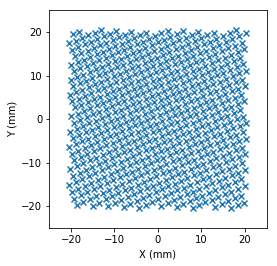

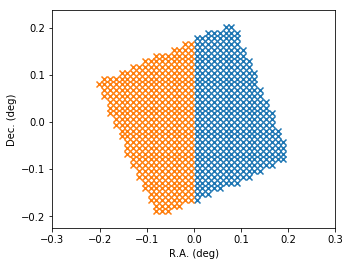

In [4]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['x'], data['y'], marker='x')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_xlim([-25,25])
ax.set_ylim([-25,25])
ax.set_aspect('equal', adjustable='box')

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='x')
ax.scatter(data['ra']-360.0, data['dec'], marker='x')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
ax.set_xlim([-0.3,0.3])
ax.set_aspect('equal', adjustable='box')

We guess the field parameters.

In [5]:
import numpy as np
from astropy.coordinates import SkyCoord, Angle

r = np.sqrt(data['x']**2.+data['y']**2.)
i0 = np.argmin(r)
ra0  = data['ra'].quantity[i0]
dec0 = data['dec'].quantity[i0]

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs')
c1 = SkyCoord(ra=data['ra'].quantity[0], dec=data['dec'].quantity[0], frame='icrs')
angle_sep = c0.separation(c1)

dx = data['x'].quantity[i0] - data['x'].quantity[0]
dy = data['y'].quantity[i0] - data['y'].quantity[0]
mm_sep = np.sqrt(dx*dx+dy*dy)

scale0 = angle_sep/mm_sep

pa0 = 0.0 * u.deg

print(ra0)
print(dec0)
print(scale0)
print(pa0)

359.99387755102043 deg
0.006122448979591855 deg
0.00744048369119173 deg / mm
0.0 deg


Here, we define a function to construct a wcs instance from given parameters.

In [6]:
from astropy.wcs import WCS
from astropy.wcs import Sip

def wcs(ra0, dec0, pa0, scale0, a=None, b=None):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale0, scale0])
    w.wcs.crval=[ra0, dec0]
    w.wcs.ctype=["RA---TAN-SIP", "DEC--TAN-SIP"]
    w.wcs.pc=[[ np.cos(pa0*u.deg), np.sin(pa0*u.deg)],
              [-np.sin(pa0*u.deg), np.cos(pa0*u.deg)]]
    if a is not None and b is not None:
        w.sip = Sip(a, b, None, None, [0, 0])
    return w

Next, we define a model function to estimate the position angle. This function calculates RA and Dec from the position on the focal plane. At this moment, we ignore the distortion.

In [7]:
def model_wo_distortion(params, pxcrd):
    # params must be an ndarray of dimension-less values.
    # assuming params = [ra, dec, pa, scale].
    ra_ptg  = params[0] # value in deg.
    dec_ptg = params[1] # value in deg.
    pa_ptg  = params[2] # value in deg.
    scale   = params[3] # value in deg/mm.
    
    w = wcs(ra_ptg, dec_ptg, pa_ptg, scale)
    world = w.all_pix2world(pixcrd, 0)

    # constraining ra and dec in 'world' between -180 to 180 deg.
    pos = np.where(world>180.)
    world[pos] = world[pos] - 360.
    pos = np.where(world<-180.)
    world[pos] = world[pos] + 360.
    
    return world.T.flatten()

Then, we make an array of the coordinates on the focal plane.

In [8]:
pixcrd = np.concatenate(([data['x']],[data['y']])).T

In [9]:
from common.leastsquare import LeastSquare

ls = LeastSquare(lambda a: model_wo_distortion(a, pixcrd), np.size(data['x'])*2)

# constructing a_init (initial parameter set).
a_init = [ra0.value, dec0.value, pa0.value, scale0.value]
a_init = np.array(a_init) # This must be an ndarray.

# constraining ra/dec values in 'observed' between -180 and 180 deg.
true_pos = np.concatenate((data['ra'], data['dec']))
pos = np.where(true_pos>180.)
true_pos[pos] = true_pos[pos] - 360.
pos = np.where(true_pos<-180.)
true_pos[pos] = true_pos[pos] + 360.

result, _ = ls.solve(true_pos, a_init, max_iteration=100)

if result[3] < 0:
    result[3] = -result[3]
    result[2] = result[2] + 180.0

if result[2] > 360.0 or result[2] < 0.0:
    result[2] = result[2]%360.0

# Showing the results.
print("Center R.A.   : {:f} deg.".format(result[0]))
print("Center Dec.   : {:f} deg.".format(result[1]))
print("Position angle: {:f} deg.".format(result[2]))
print("Plate scale   : {:e} deg/mm".format(result[3]))
    
# Updating the field parameters.
ra0    = result[0] * u.deg
dec0   = result[1] * u.deg
pa0    = result[2] * u.deg
scale0 = result[3] * u.deg/u.mm

2021-07-10 12:31:59,639  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 23.765348)
2021-07-10 12:31:59,654  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.378433)
2021-07-10 12:31:59,667  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.031170)
2021-07-10 12:31:59,680  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000001)
2021-07-10 12:31:59,693  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-07-10 12:31:59,701  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-07-10 12:31:59,708  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-07-10 12:31:59,715  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-07

Center R.A.   : 360.010240 deg.
Center Dec.   : -0.002371 deg.
Position angle: 23.418078 deg.
Plate scale   : 7.765222e-03 deg/mm


We define a model function which calculates RA and Dec from the position on the focal plane with considering the distortion. It is represented by the Sip function implemented to astropy.wcs.

In [10]:
def model(params, pxcrd, sip_order):
    # params must be an ndarray of dimension-less values.
    # assuming params = [ra, dec, pa, scale, a00, a01, ..., a0m, a10, a11, ..., amm, b00, b01, ..., bmm].
    ra_ptg  = params[0] # value in deg.
    dec_ptg = params[1] # value in deg.
    pa_ptg  = params[2] # value in deg.
    scale   = params[3] # value in deg/mm.
    a = params[4:4+(sip_order+1)**2].reshape((sip_order+1, sip_order+1))
    b = params[4+(sip_order+1)**2:4+2*(sip_order+1)**2].reshape((sip_order+1, sip_order+1))
    # constraining some parametes to be zero.
    m, n = np.indices((sip_order+1, sip_order+1))
    pos = np.where((m+n==0)+(m+n==1)+(m+n>sip_order))
    a[pos] = 0.
    b[pos] = 0.
    
    w = wcs(ra_ptg, dec_ptg, pa_ptg, scale, a, b)
    world = w.all_pix2world(pixcrd, 0)

    # constraining ra and dec in 'world' between -180 to 180 deg.
    pos = np.where(world>180.)
    world[pos] = world[pos] - 360.
    pos = np.where(world<-180.)
    world[pos] = world[pos] + 360.
    
    return world.T.flatten()

And now, we estimate the field and distortion parameters with the LeastSquare module. Here, we set the sip order to be 4.

In [11]:
from common.leastsquare import LeastSquare

sip_order = 4

ls = LeastSquare(lambda a: model(a, pixcrd, sip_order), np.size(data['x'])*2)

# constructing a_init (initial parameter set).
a_init = [ra0.value, dec0.value, pa0.value, scale0.value]
for i in range(0, 2*(sip_order+1)**2):
    a_init.append(0)
a_init = np.array(a_init) # This must be an ndarray.

# constraining ra/dec values in 'observed' between -180 and 180 deg.
true_pos = np.concatenate((data['ra'], data['dec']))
pos = np.where(true_pos>180.)
true_pos[pos] = true_pos[pos] - 360.
pos = np.where(true_pos<-180.)
true_pos[pos] = true_pos[pos] + 360.

result, _ = ls.solve(true_pos, a_init, max_iteration=100)

if result[3] < 0:
    result[3] = -result[3]
    result[2] = result[2] + 180.0

if result[2] > 360.0 or result[2] < 0.0:
    result[2] = result[2]%360.0

2021-07-10 12:32:12,621  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-10 12:32:12,625  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.002700)
2021-07-10 12:32:12,758  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-10 12:32:12,761  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000031)
2021-07-10 12:32:12,848  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-10 12:32:12,850  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-07-10 12:32:12,937  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-10 12:32:12,940  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm 

The result is...

In [13]:
print("Center R.A.   : {:f} deg.".format(result[0]))
print("Center Dec.   : {:f} deg.".format(result[1]))
print("Position angle: {:f} deg.".format(result[2]))
print("Plate scale   : {:e} deg/mm".format(result[3]))

Center R.A.   : 360.010359 deg.
Center Dec.   : -0.004075 deg.
Position angle: 23.416817 deg.
Plate scale   : 7.883529e-03 deg/mm


In [14]:
print(result[4:4+(sip_order+1)**2].reshape((sip_order+1, sip_order+1)))
print(result[4+(sip_order+1)**2:].reshape((sip_order+1, sip_order+1)))

[[ 0.00000000e+00  0.00000000e+00 -1.41877396e-04 -1.73147526e-06
   6.58393338e-08]
 [ 0.00000000e+00  8.47034136e-04 -4.01843695e-05 -2.07856149e-07
   0.00000000e+00]
 [-3.70725065e-04 -1.29634560e-06  1.36164955e-07  0.00000000e+00
   0.00000000e+00]
 [-4.02142769e-05 -2.09643276e-07  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.38010713e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00  1.23182077e-03 -4.39655822e-05
  -1.71751167e-07]
 [ 0.00000000e+00 -2.80190925e-04 -1.60118081e-06  1.35537563e-07
   0.00000000e+00]
 [ 4.02932880e-04 -4.29046331e-05 -2.64795365e-07  0.00000000e+00
   0.00000000e+00]
 [-1.82221786e-06  1.32208049e-07  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.12135825e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


According to the meta part of the input file, the poiunting RA and Dec are 0.0 deg. The position angle is 23.418573474700626 deg. The calculation seems to correctly estimate these parameters.

Let's compare the ra/dec values calculated from the derived parameters with the true values.

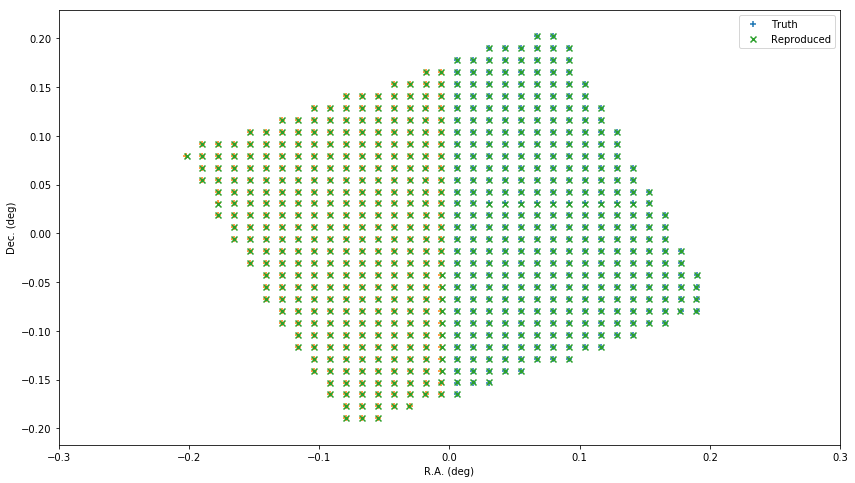

In [15]:
positions = model(result, pixcrd, sip_order)
positions = positions.reshape((2,int(positions.size/2))).T

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='+', label='Truth')
ax.scatter(data['ra']-360., data['dec'], marker='+', label='')
ax.scatter(positions[:,0], positions[:,1], marker='x', label='Reproduced')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
ax.set_xlim([-0.3,0.3])
#ax.set_aspect('equal', adjustable='box')
ax.legend()

The reproduced ra/dec values seem to match the true values very well.

In [16]:
from astropy.coordinates import SkyCoord

c_calc = SkyCoord(positions[:,0]*u.deg, positions[:,1]*u.deg, frame='icrs')
c_true = SkyCoord(data['ra'], data['dec'], frame='icrs')
sep = c_calc.separation(c_true)

Text(0, 0.5, 'Position estimation error (arcsec)')

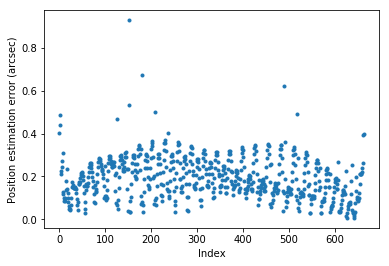

In [17]:
plt.plot(sep.arcsec, '.')
plt.xlabel('Index')
plt.ylabel('Position estimation error (arcsec)')

The position difference is small, typically around <0.3 arcsec.